# Correlating NYT Data with Market Data

### Loading in Data

In [305]:
import os
import json
import time
import requests
import datetime
import dateutil
import pandas as pd
import glob
import string
from dateutil.relativedelta import relativedelta
import numpy as np
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg 
import matplotlib.pyplot as plt

In [2]:
spy = yf.download("SPY")
demsent = pd.read_csv("./Data/DailyDemFiltered.csv")
repsent = pd.read_csv("./Data/DailyRepFiltered.csv")

demsent = demsent.set_index("date")
demsent = demsent.drop(columns = ['Unnamed: 0'])
repsent = repsent.set_index("date")
repsent = repsent.drop(columns = ['Unnamed: 0'])

xlk = yf.download("XLK")
xlv = yf.download("XLV")
xlf = yf.download("XLF")
xly = yf.download("XLY")
xli = yf.download("XLI")
xlp = yf.download("XLP")
xlu = yf.download("XLU")
xle = yf.download("XLE")
xlc = yf.download("XLC")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
listOfFunds = [spy , xlk , xlv, xlf, xly , xli, xlp, xlu, xle, xlc]
EtfNames = ["spy" , "xlk" , "xlv", "xlf", "xly" , "xli", "xlp", "xlu", "xle", "xlc"]
for etf in listOfFunds:
    etf["Log Returns"] = np.log(etf["Close"]/etf["Close"].shift(1))
spy.head()

,Open,High,Low,Close,Adj Close,Volume,Log Returns
Date,,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.079659,1003200,NaN
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.265144,480500,0.007087
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.320782,201300,0.002116
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.599014,529400,0.010515
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.710312,531500,0.004175


In [263]:
# get correct indicies
spy , xlk , xlv, xlf, xly , xli, xlp, xlu, xle, xlc = spy['2020-10-01':'2020-11-29'] , xlk['2020-10-01':'2020-11-29'] , xlv['2020-10-01':'2020-11-29'], xlf['2020-10-01':'2020-11-29'], xly['2020-10-01':'2020-11-29'] , xli['2020-10-01':'2020-11-29'], xlp['2020-10-01':'2020-11-29'], xlu['2020-10-01':'2020-11-29'], xle['2020-10-01':'2020-11-29'], xlc['2020-10-01':'2020-11-29']
spy.tail()
listOfFunds = [spy , xlk , xlv, xlf, xly , xli, xlp, xlu, xle, xlc]


In [240]:
def cor(sentiment, logReturns, lag = 0):
    '''Returns the correlation between the two timeseries with given lag.'''
    cor = logReturns.corr(sentiment.shift(lag))
    return cor

In [241]:
#Get maximum correlation for each party and etf
demMax = {}
repMax = {}
for party in [repsent, demsent]:
    demParty = party is demsent
    for i, fund in enumerate(listOfFunds):
        sent, returns = party["sentiment score"], fund["Log Returns"]
        maxCor = max([[cor(sent, returns, x), abs(cor(sent, returns, x)), x] for x in range(10)], key = lambda x: x[1])
        etfName = EtfNames[i]
        if demParty:
            demMax[etfName] = {"correlation": maxCor[0], "shift": maxCor[2]}
        else:
            repMax[etfName] = {"correlation": maxCor[0], "shift": maxCor[2]}

In [321]:
repCorDf = pd.DataFrame(data=repMax).T
demCorDf = pd.DataFrame(data=demMax).T

repCorDf

,correlation,shift
spy,0.334828,7.0
xlk,0.350097,1.0
xlv,0.288537,0.0
xlf,0.208759,3.0
xly,0.373362,7.0
xli,0.265135,7.0
xlp,0.489167,7.0
xlu,0.486614,7.0
xle,-0.221128,1.0
xlc,0.256602,7.0


In [266]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(demsent.values)
#Testing if we can use the arima model with our data--all worked except XLE
print("Dem ADF test")
print('ADF Statistic: %f' % result[0])
print('ADF p-value: %f' % result[1] + "\n")
result = adfuller(repsent.values)
print("Rep ADF test")
print('ADF Statistic: %f' % result[0])
print('ADF p-value: %f' % result[1] + "\n")

for i, etf in enumerate(listOfFunds):
    result = adfuller(etf["Log Returns"].values)
    print(EtfNames[i] + " ADF test")
    print('ADF Statistic: %f' % result[0])
    print('ADF p-value: %f' % result[1] + "\n")

Dem ADF test
ADF Statistic: -6.262063
ADF p-value: 0.000000

Rep ADF test
ADF Statistic: -2.987801
ADF p-value: 0.036049

spy ADF test
ADF Statistic: -3.048336
ADF p-value: 0.030620

xlk ADF test
ADF Statistic: -3.274260
ADF p-value: 0.016069

xlv ADF test
ADF Statistic: -5.397231
ADF p-value: 0.000003

xlf ADF test
ADF Statistic: -6.327157
ADF p-value: 0.000000

xly ADF test
ADF Statistic: -6.640880
ADF p-value: 0.000000

xli ADF test
ADF Statistic: -5.671645
ADF p-value: 0.000001

xlp ADF test
ADF Statistic: -5.349975
ADF p-value: 0.000004

xlu ADF test
ADF Statistic: -5.657926
ADF p-value: 0.000001

xle ADF test
ADF Statistic: -1.968537
ADF p-value: 0.300537

xlc ADF test
ADF Statistic: -7.235476
ADF p-value: 0.000000



## Model Creation

In [267]:
from statsmodels.tsa.arima_model import ARIMA

spy Dem predictive model


C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                 112.896
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 03 Dec 2020   AIC                           -215.792
Time:                        19:31:24   BIC                           -207.874
Sample:                             0   HQIC                          -213.028
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0008      0.003     -0.320      0.749      -0.006       0.004
sentiment score       0.0333      0.012      2.796      0.005       0.010       0.057
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                 100.117
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 03 Dec 2020   AIC                           -190.233
Time:                        19:31:24   BIC                           -182.316
Sample:                             0   HQIC                          -187.470
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0017      0.003     -0.518      0.604      -0.008       0.005
sentiment score       0.0346      0.017      1.982      0.048       0.000       0.069
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   41
Model:                     ARMA(1, 1)   Log Likelihood                 124.603
Method:                       css-mle   S.D. of innovations              0.012
Date:                Thu, 03 Dec 2020   AIC                           -239.207
Time:                        19:31:25   BIC                           -230.639
Sample:                             0   HQIC                          -236.087
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0016      0.003     -0.622      0.534      -0.007       0.003
sentiment score       0.0307      0.013      2.345      0.019       0.005       0.056
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                  96.043
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 03 Dec 2020   AIC                           -182.086
Time:                        19:31:26   BIC                           -174.168
Sample:                             0   HQIC                          -179.322
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0021      0.002     -0.992      0.321      -0.006       0.002
sentiment score       0.0635      0.020      3.228      0.001       0.025       0.102
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                 109.807
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 03 Dec 2020   AIC                           -209.615
Time:                        19:31:26   BIC                           -201.697
Sample:                             0   HQIC                          -206.851
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0008      0.002     -0.306      0.759      -0.006       0.004
sentiment score       0.0253      0.013      1.954      0.051   -8.13e-05       0.051
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                 103.544
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 03 Dec 2020   AIC                           -197.089
Time:                        19:31:27   BIC                           -189.171
Sample:                             0   HQIC                          -194.325
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0009      0.003     -0.323      0.747      -0.006       0.005
sentiment score       0.0460      0.015      3.044      0.002       0.016       0.076
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\smuke\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency i

                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   40
Model:                     ARMA(1, 1)   Log Likelihood                 132.275
Method:                       css-mle   S.D. of innovations              0.009
Date:                Thu, 03 Dec 2020   AIC                           -254.551
Time:                        19:31:28   BIC                           -246.106
Sample:                             0   HQIC                          -251.497
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0005      0.002     -0.285      0.776      -0.004       0.003
sentiment score       0.0166      0.010      1.678      0.093      -0.003       0.036
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                  75.139
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 03 Dec 2020   AIC                           -140.279
Time:                        19:31:29   BIC                           -132.361
Sample:                             0   HQIC                          -137.516
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0030      0.006     -0.477      0.634      -0.015       0.009
sentiment score       0.1181      0.034      3.525      0.000       0.052       0.184
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                 103.578
Method:                       css-mle   S.D. of innovations              0.013
Date:                Thu, 03 Dec 2020   AIC                           -197.156
Time:                        19:31:30   BIC                           -189.238
Sample:                             0   HQIC                          -194.392
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.171e-05      0.001      0.044      0.965      -0.003       0.003
sentiment score       0.0252      0.014      1.864      0.062      -0.001       0.052
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                 106.030
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 03 Dec 2020   AIC                           -202.061
Time:                        19:31:30   BIC                           -194.429
Sample:                             0   HQIC                          -199.458
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0046      0.003      1.392      0.164      -0.002       0.011
sentiment score       0.0592      0.021      2.824      0.005       0.018       0.100
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   40
Model:                     ARMA(1, 1)   Log Likelihood                 111.503
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 03 Dec 2020   AIC                           -213.006
Time:                        19:31:31   BIC                           -204.561
Sample:                             0   HQIC                          -209.953
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0040      0.002      1.688      0.091      -0.001       0.009
sentiment score       0.0629      0.025      2.523      0.012       0.014       0.112
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   41
Model:                     ARMA(1, 1)   Log Likelihood                 123.422
Method:                       css-mle   S.D. of innovations              0.012
Date:                Thu, 03 Dec 2020   AIC                           -236.845
Time:                        19:31:31   BIC                           -228.277
Sample:                             0   HQIC                          -233.725
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0027      0.002      1.131      0.258      -0.002       0.007
sentiment score       0.0344      0.020      1.682      0.093      -0.006       0.075
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   38
Model:                     ARMA(1, 1)   Log Likelihood                  97.647
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 03 Dec 2020   AIC                           -185.294
Time:                        19:31:32   BIC                           -177.106
Sample:                             0   HQIC                          -182.381
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0059      0.003      1.741      0.082      -0.001       0.013
sentiment score       0.0423      0.033      1.268      0.205      -0.023       0.108
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                 106.015
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 03 Dec 2020   AIC                           -202.030
Time:                        19:31:32   BIC                           -194.398
Sample:                             0   HQIC                          -199.427
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0051      0.003      1.448      0.148      -0.002       0.012
sentiment score       0.0774      0.022      3.561      0.000       0.035       0.120
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\smuke\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                  94.157
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 03 Dec 2020   AIC                           -178.313
Time:                        19:31:33   BIC                           -170.681
Sample:                             0   HQIC                          -175.711
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0048      0.003      1.591      0.112      -0.001       0.011
sentiment score       0.0417      0.031      1.368      0.171      -0.018       0.102
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                 117.105
Method:                       css-mle   S.D. of innovations              0.008
Date:                Thu, 03 Dec 2020   AIC                           -224.210
Time:                        19:31:33   BIC                           -216.578
Sample:                             0   HQIC                          -221.607
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0037      0.003      1.451      0.147      -0.001       0.009
sentiment score       0.0583      0.014      4.060      0.000       0.030       0.087
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                 107.784
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 03 Dec 2020   AIC                           -205.568
Time:                        19:31:34   BIC                           -197.937
Sample:                             0   HQIC                          -202.966
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0030      0.002      1.519      0.129      -0.001       0.007
sentiment score       0.0616      0.019      3.239      0.001       0.024       0.099
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   40
Model:                     ARMA(1, 1)   Log Likelihood                  80.373
Method:                       css-mle   S.D. of innovations              0.032
Date:                Thu, 03 Dec 2020   AIC                           -150.746
Time:                        19:31:35   BIC                           -142.301
Sample:                             0   HQIC                          -147.692
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0036      0.006      0.624      0.533      -0.008       0.015
sentiment score      -0.0775      0.054     -1.429      0.153      -0.184       0.029
ar.L1.Log Returns    -0.

C:\Users\smuke\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:            Log Returns   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                  95.105
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 03 Dec 2020   AIC                           -180.210
Time:                        19:31:36   BIC                           -172.579
Sample:                             0   HQIC                          -177.608
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0047      0.003      1.500      0.134      -0.001       0.011
sentiment score       0.0469      0.031      1.511      0.131      -0.014       0.108
ar.L1.Log Returns     0.

C:\Users\smuke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


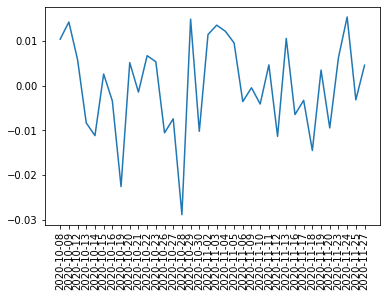

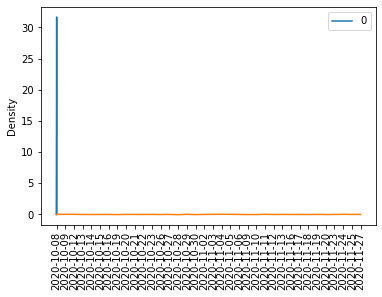

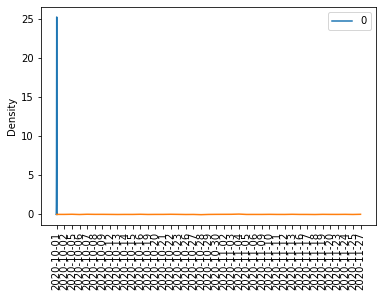

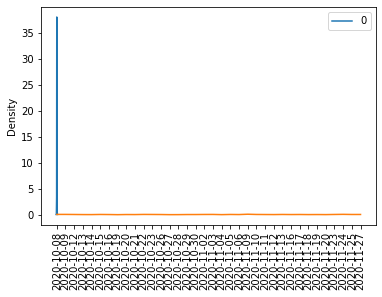

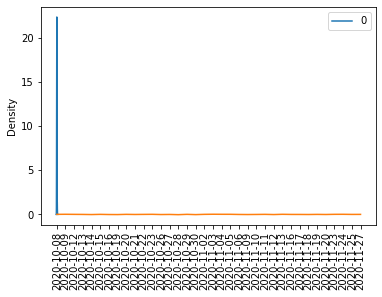

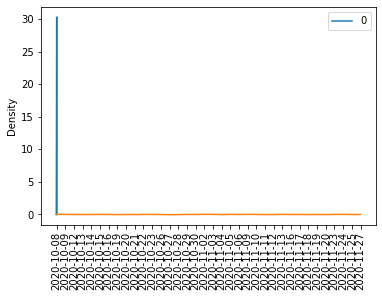

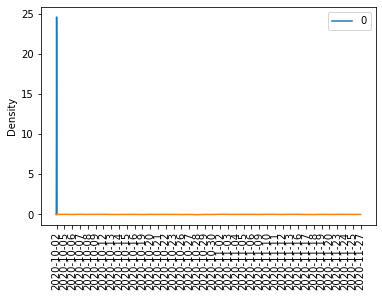

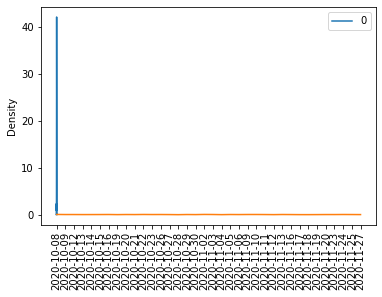

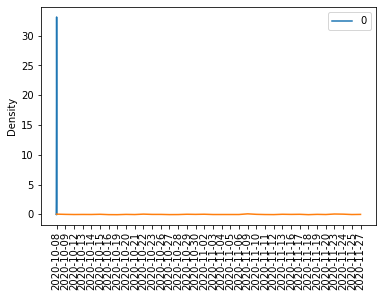

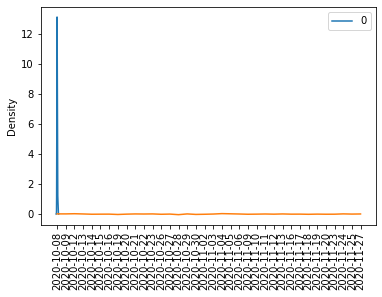

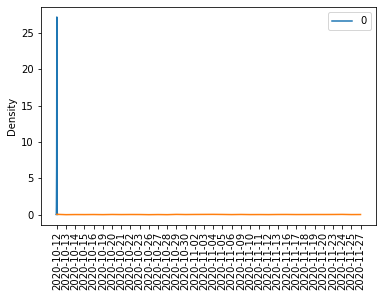

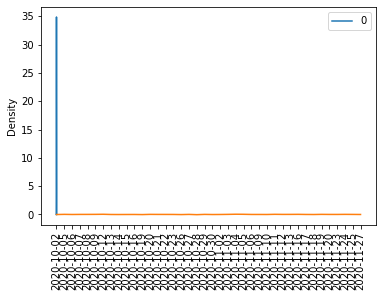

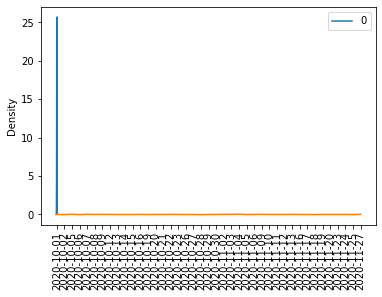

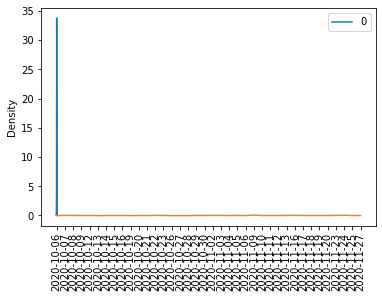

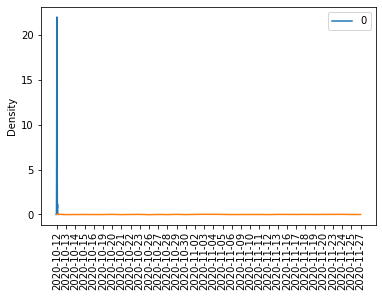

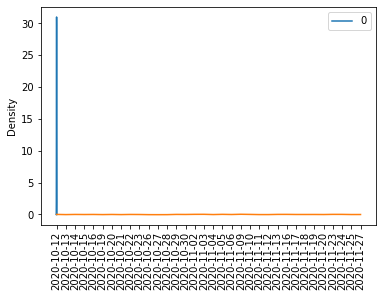

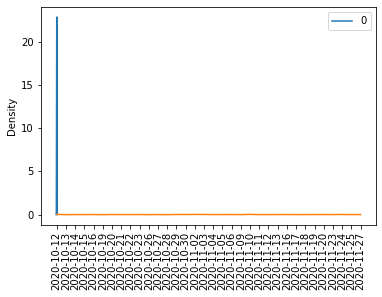

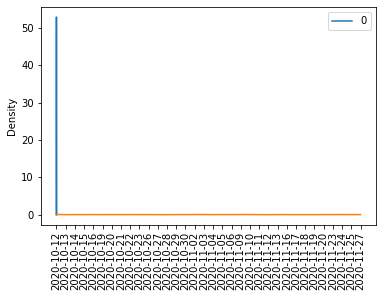

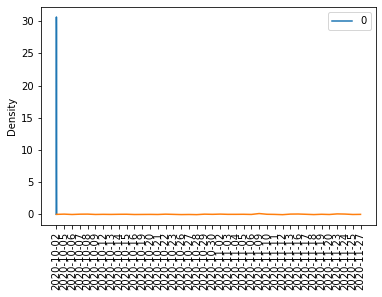

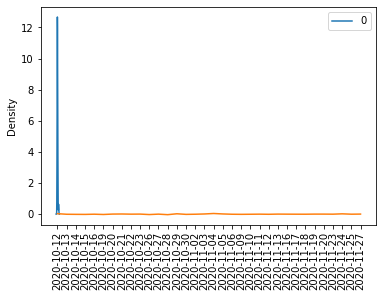

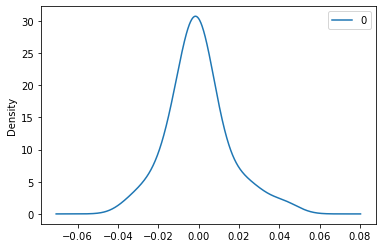

In [320]:
# SRC: https://machinelearningpy.com/time-series/arima-time-series-forecasting-python-exhaustive-guide/#Overview_of_ARIMA_Time_Series_Forecasting
for i, etf in enumerate(listOfFunds):
    EtfName = EtfNames[i]
    print(EtfName, "Dem predictive model")
    shift = int(demCorDf.loc[EtfName]["shift"])
    exog_model = ARIMA(etf["Log Returns"][shift:], exog=demsent.shift(shift).dropna(), order = (1, 0, 1)) 
    exog_fit = exog_model.fit()
    print(exog_fit.summary())

    residuals = pd.DataFrame(exog_fit.resid)
    plt.plot(residuals)
    plt.xticks(rotation=90)

    # density plot
    residuals.plot(kind='kde')
    
for i, etf in enumerate(listOfFunds):
    EtfName = EtfNames[i]
    print(EtfName, "Rep predictive model")
    shift = int(repCorDf.loc[EtfName]["shift"])
    exog_model = ARIMA(etf["Log Returns"][shift:], exog=repsent.shift(shift).dropna(), order = (1, 0, 1)) 
    exog_fit = exog_model.fit()
    print(exog_fit.summary())

    residuals = pd.DataFrame(exog_fit.resid)
    plt.plot(residuals)
    plt.xticks(rotation=90)

    # density plot
    residuals.plot(kind='kde')